### Import

In [1]:
import re # 정규표현식 관련된 작업에 필요한 패키지
import os # I/O 관련된 작업에 필요한 패키지 
import pandas as pd # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np # 데이터 array 작업에 필요한 패키지
import tensorflow as tf # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split # 데이터 전처리에 필요한 패키지

### Setting

In [38]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 18

### DataSet


    - 총 5,856개의 X-Ray 이미지, 2개의 범주 (폐렴/정상)
    - 3개의 하위 데릭토리 (train, test, val)
        - train : 5216개
        - test : 624개
        - validation : 16개
    - validation이 부족하여서 train에서 더 가져온다
        - train : 4185개
        - test : 624개
        - validation : 1047개

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
train_filenames[0]

'/home/aiffel-dj51/aiffel/chest_xray/train/NORMAL/NORMAL2-IM-1224-0001.jpeg'

### Preprocess

In [5]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
filenames[0]

'/home/aiffel-dj51/aiffel/chest_xray/train/NORMAL/NORMAL2-IM-1224-0001.jpeg'

#### 데이터의 클래스 불균형(imbalance)
 - 정상보다 폐렴 이미지수가 3배가 더 많기 때문에 학습이 잘 진행되지 않을 것이다.
     - CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘한다.

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1069
Pneumonia images count in training set: 3116


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [10]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


#### dataset을 만들 함수 선언

   - get_label
        - 파일의 경로로부터 문자열 처리를 통해서 label 추출
   - decode_img
        - 이미지파일을 tensor로 변환 후, resize
   - process_path
        - 위에서 선언한 get_label로 경로를 가져온다
        - tf.io.read_file을 이용해서 경로로부터 이미지를 읽는다
        - 위에서 선언한 decode_img로 tensor로 전환, 이미지 resize


In [11]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [12]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### 데이터셋 만들기
-  map을 활용해서 process_path 함수를 적용한다.

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [15]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_basic = prepare_for_training(train_ds)
val_ds_basic = prepare_for_training(val_ds)

### Augmentation

In [17]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_aug_ds = prepare_for_training_aug(train_ds)
val_aug_ds = prepare_for_training_aug(val_ds)

### Visualization

#### basic

(16, 180, 180, 3)
(16,)


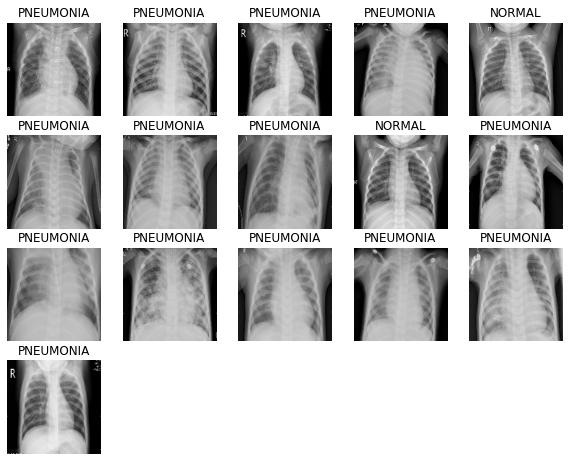

In [18]:
image_batch, label_batch = next(iter(train_ds_basic))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

#### aug

(16, 180, 180, 3)
(16,)


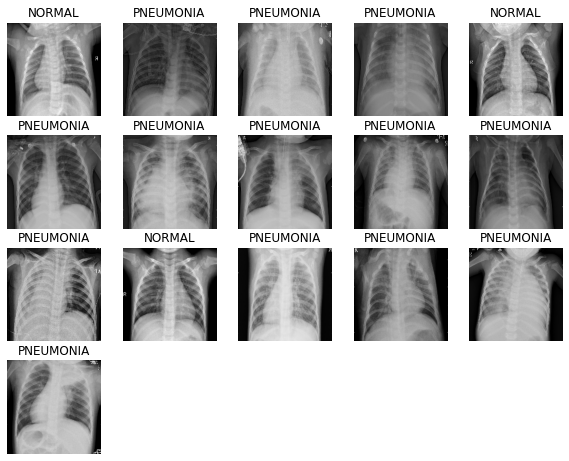

In [19]:
image_aug_batch, label_aug_batch = next(iter(train_aug_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_aug_batch.numpy(), label_aug_batch.numpy())

### Model

In [20]:
def conv_block(layer, filters):
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(layer)
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    return x

In [21]:
def dense_block(layer, units, dropout_rate=0.5, dropout=True):
    x = tf.keras.layers.Dense(units, activation='relu')(layer)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    return x

In [22]:
def build_model(dropout=True):
    input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    
    x = conv_block(x, 128)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = conv_block(x, 256)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = dense_block(x, 512, 0.7)
    x = dense_block(x, 128, 0.5)
    x = dense_block(x, 64, 0.3)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    
    return model

### Imbalance

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


### Train

#### basic

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [39]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/18
261/261 [==============================] - 22s 85ms/step - loss: 0.0313 - accuracy: 0.9883 - precision: 0.9971 - recall: 0.9871 - val_loss: 0.0639 - val_accuracy: 0.9798 - val_precision: 0.9855 - val_recall: 0.9868
Epoch 2/18
261/261 [==============================] - 22s 84ms/step - loss: 0.0610 - accuracy: 0.9820 - precision: 0.9951 - recall: 0.9807 - val_loss: 0.7119 - val_accuracy: 0.7019 - val_precision: 0.9978 - val_recall: 0.5945
Epoch 3/18
261/261 [==============================] - 22s 85ms/step - loss: 0.0377 - accuracy: 0.9866 - precision: 0.9974 - recall: 0.9846 - val_loss: 0.0588 - val_accuracy: 0.9798 - val_precision: 0.9960 - val_recall: 0.9764
Epoch 4/18
261/261 [==============================] - 22s 84ms/step - loss: 0.0271 - accuracy: 0.9904 - precision: 0.9981 - recall: 0.9891 - val_loss: 0.0567 - val_accuracy: 0.9817 - val_precision: 0.9907 - val_recall: 0.9842
Epoch 5/18
261/261 [==============================] - 22s 84ms/step - loss: 0.0132 - accuracy: 0

#### basic + augmentation

In [41]:
with tf.device('/GPU:0'):
    model_aug = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [42]:
with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_aug_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_aug_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/18
261/261 [==============================] - 23s 87ms/step - loss: 0.4628 - accuracy: 0.7713 - precision: 0.9378 - recall: 0.7421 - val_loss: 0.6261 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/18
261/261 [==============================] - 23s 86ms/step - loss: 0.2729 - accuracy: 0.8882 - precision: 0.9664 - recall: 0.8803 - val_loss: 1.1753 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/18
261/261 [==============================] - 22s 86ms/step - loss: 0.2222 - accuracy: 0.9140 - precision: 0.9722 - recall: 0.9107 - val_loss: 0.3085 - val_accuracy: 0.8442 - val_precision: 0.8245 - val_recall: 1.0000
Epoch 4/18
261/261 [==============================] - 22s 84ms/step - loss: 0.2008 - accuracy: 0.9239 - precision: 0.9748 - recall: 0.9214 - val_loss: 0.2433 - val_accuracy: 0.8990 - val_precision: 0.9985 - val_recall: 0.8633
Epoch 5/18
261/261 [==============================] - 22s 84ms/step - loss: 0.1856 - accuracy: 0

#### no dropout

In [43]:
with tf.device('/GPU:0'):
    model_no_drop = build_model(dropout=False)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no_drop.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
with tf.device('/GPU:0'):
    history_no_drop = model_no_drop.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/18
261/261 [==============================] - 22s 86ms/step - loss: 0.3215 - accuracy: 0.8496 - precision: 0.9669 - recall: 0.8264 - val_loss: 0.5982 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/18
261/261 [==============================] - 22s 85ms/step - loss: 0.2117 - accuracy: 0.9298 - precision: 0.9766 - recall: 0.9280 - val_loss: 0.8009 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/18
261/261 [==============================] - 22s 85ms/step - loss: 0.1679 - accuracy: 0.9404 - precision: 0.9824 - recall: 0.9366 - val_loss: 0.5029 - val_accuracy: 0.7702 - val_precision: 0.7610 - val_recall: 1.0000
Epoch 4/18
261/261 [==============================] - 22s 85ms/step - loss: 0.1773 - accuracy: 0.9332 - precision: 0.9807 - recall: 0.9287 - val_loss: 2.4697 - val_accuracy: 0.5202 - val_precision: 1.0000 - val_recall: 0.3460
Epoch 5/18
261/261 [==============================] - 22s 84ms/step - loss: 0.1444 - accuracy: 0

#### no dropout + Ir scheduler

In [45]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.7, monitor='val_loss', patience=1, verbose=2, min_lr=1e-8)

In [46]:
with tf.device('/GPU:0'):
    model_no_drop_lr = build_model(dropout=False)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no_drop_lr.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [47]:
with tf.device('/GPU:0'):
    history_no_drop_lr = model_no_drop_lr.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[lr_scheduler],
    )

Epoch 1/18
261/261 [==============================] - 23s 87ms/step - loss: 0.3623 - accuracy: 0.8281 - precision: 0.9617 - recall: 0.8008 - val_loss: 0.6851 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/18
261/261 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9162 - precision: 0.9768 - recall: 0.9090
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
261/261 [==============================] - 22s 86ms/step - loss: 0.2201 - accuracy: 0.9162 - precision: 0.9768 - recall: 0.9090 - val_loss: 1.3347 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/18
261/261 [==============================] - 22s 85ms/step - loss: 0.1655 - accuracy: 0.9344 - precision: 0.9813 - recall: 0.9296 - val_loss: 0.2334 - val_accuracy: 0.9038 - val_precision: 0.8840 - val_recall: 1.0000 - lr: 7.0000e-04
Epoch 4/18
261/261 [==============================] - ETA: 0s - loss: 0.1567 

### Evaluate

In [49]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 57ms/step - loss: 1.8097 - accuracy: 0.8205 - precision: 0.7814 - recall: 0.9897


In [50]:
loss, acc, prec, rec = model_aug.evaluate(test_ds)

39/39 [==============================] - 2s 57ms/step - loss: 0.5810 - accuracy: 0.8462 - precision: 0.8419 - recall: 0.9282


In [51]:
loss, acc, prec, rec = model_no_drop.evaluate(test_ds)

39/39 [==============================] - 2s 57ms/step - loss: 0.4885 - accuracy: 0.8718 - precision: 0.8780 - recall: 0.9231


In [52]:
loss, acc, prec, rec = model_no_drop_lr.evaluate(test_ds)

39/39 [==============================] - 2s 57ms/step - loss: 0.6718 - accuracy: 0.8045 - precision: 0.7669 - recall: 0.9872


### Result

#### basic vs augmentation

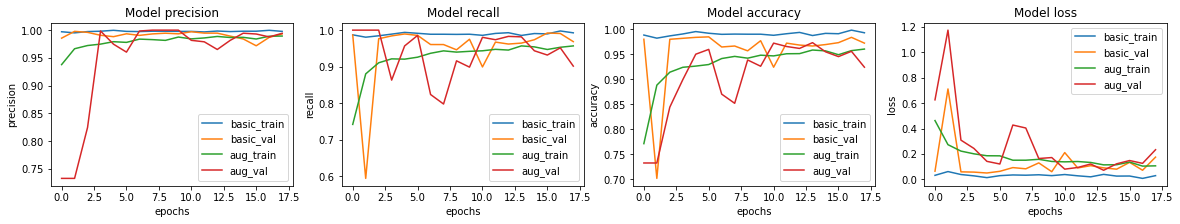

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['basic_train', 'basic_val', 'aug_train', 'aug_val'])

#### augmentation vs no drop

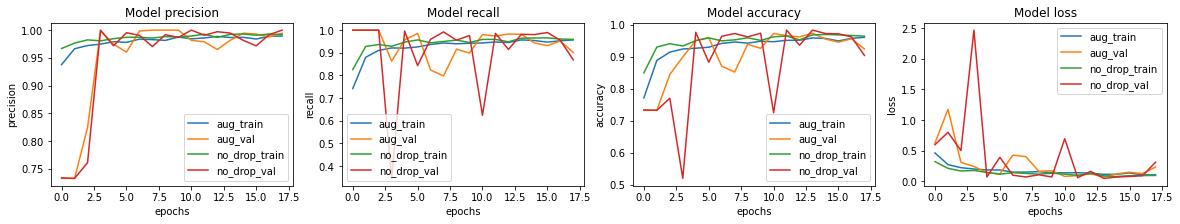

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].plot(history_no_drop.history[met])
    ax[i].plot(history_no_drop.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['aug_train', 'aug_val','no_drop_train', 'no_drop_val'])

#### no drop  vs no drop + lr scheduler

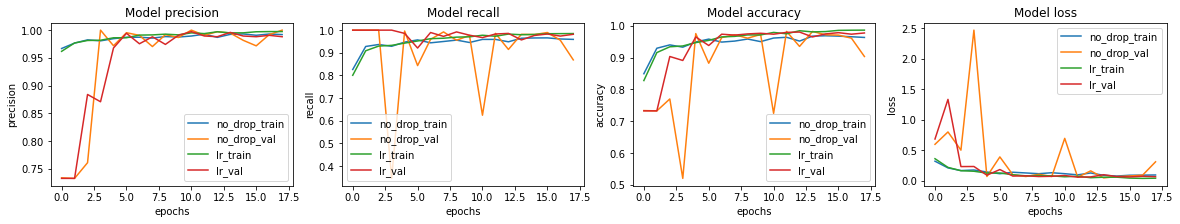

In [55]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_drop.history[met])
    ax[i].plot(history_no_drop.history['val_' + met])
    ax[i].plot(history_no_drop_lr.history[met])
    ax[i].plot(history_no_drop_lr.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['no_drop_train', 'no_drop_val', 'lr_train', 'lr_val',])

### 느낀점 (회고)



캐글의 Chest X-Ray Images dataset을 가지고 폐렴을 진단하는 모델을 만들었습니다.

기본 모델을 만들고 모델을 개선하기 위한 여러가지 방법을 적용해보고 결과를 비교하였습니다.

    1. basic model vs basic model + data augmentation
    기본 모델과 data augmentation을 이용한 모델을 비교하였습니다. data augmentation은 이미지를 좌우반전하여 적용하였습니다.


    2. basic model + data augmentation vs without drop
    data augmentation을 이용한 모델과 dropout을 제거한 모델을 비교하였습니다.


    3. without drop vs without drop + learning rate scheduler
    2.에서의 dropout을 제거한 모델과 그 모델에 learning rate scheduler를 추가한 모델을 비교하였습니다.


no dropout 모델이 0.8718로 성능이 가장 좋게 나왔습니다.
